In [80]:
import numpy as np
import cv2
import pywt
from scipy.linalg import svd, diagsvd
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt

<h1>DWT</h1>

In [81]:
def dwt_watermark_embedding(image, watermark, alpha):

    coeffs = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs
    watermark_resized = cv2.resize(watermark, (LL.shape[1], LL.shape[0]))
    LL_marked = LL + alpha * watermark_resized
    marked_image = pywt.idwt2((LL_marked, (LH, HL, HH)), 'haar')

    return marked_image


def extracted_watermark_dwt(marked_image, original_image, alpha):

    coeffs_marked = pywt.dwt2(marked_image, 'haar')
    coeffs_original = pywt.dwt2(original_image, 'haar')
    LL_marked, _ = coeffs_marked
    LL_original, _ = coeffs_original
    extracted_watermark = (LL_marked - LL_original) / alpha

    return extracted_watermark

<h1>DWT + SVD</h1>

In [82]:
def dwt_svd_watermark_embedding(image, watermark, alpha):

    coeffs = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs
    watermark_resized = cv2.resize(watermark, (LL.shape[1], LL.shape[0]))
    U, S, V = svd(LL)
    Uw, Sw, Vw = svd(watermark_resized)
    S_marked = S + alpha * Sw[:len(S)]
    LL_marked = np.dot(U[:, :len(S)], np.dot(diagsvd(S_marked, len(S), len(S)), V[:len(S), :]))
    marked_image = pywt.idwt2((LL_marked, (LH, HL, HH)), 'haar')

    return marked_image

def dwt_svd_watermark_extraction(marked_image, original_image, alpha):

    coeffs_marked = pywt.dwt2(marked_image, 'haar')
    coeffs_original = pywt.dwt2(original_image, 'haar')
    LL_marked, _ = coeffs_marked
    LL_original, _ = coeffs_original
    _, S_marked, _ = svd(LL_marked)
    _, S_original, _ = svd(LL_original)
    extracted_watermark = (S_marked - S_original) / alpha
    
    return extracted_watermark


<h1>Runing Functions</h1>

In [90]:
image = cv2.imread('/content/2.jpg', cv2.IMREAD_GRAYSCALE)
watermark = cv2.imread('/content/logo.png', cv2.IMREAD_GRAYSCALE)
alpha = 0.3


In [84]:
marked_image_dwt = dwt_watermark_embedding(image, watermark, alpha)
marked_image_dwt_svd = dwt_svd_watermark_embedding(image, watermark, alpha)


In [85]:
marked_image_dwt

array([[87.25, 87.25, 87.25, ..., 87.5 , 87.5 , 87.5 ],
       [87.25, 87.25, 87.25, ..., 87.5 , 87.5 , 87.5 ],
       [87.25, 87.25, 87.25, ..., 87.5 , 87.5 , 87.5 ],
       ...,
       [90.5 , 90.5 , 90.5 , ..., 65.25, 65.25, 65.25],
       [93.25, 94.25, 94.25, ..., 60.5 , 60.5 , 60.5 ],
       [93.25, 94.25, 94.25, ..., 60.5 , 60.5 , 60.5 ]])

In [86]:
marked_image_dwt_svd

array([[65.60390113, 65.60390113, 65.60748575, ..., 69.06405275,
        68.98682083, 68.98682083],
       [65.60390113, 65.60390113, 65.60748575, ..., 69.06405275,
        68.98682083, 68.98682083],
       [65.39390457, 65.39390457, 65.4375769 , ..., 69.24201514,
        69.19633838, 69.19633838],
       ...,
       [70.12188519, 70.12188519, 70.23253202, ..., 36.43431253,
        36.40501141, 36.40501141],
       [69.01779194, 70.01779194, 70.1142578 , ..., 35.44817104,
        35.41922432, 35.41922432],
       [69.01779194, 70.01779194, 70.1142578 , ..., 35.44817104,
        35.41922432, 35.41922432]])

In [87]:
extracted_watermark_dwt = dwt_watermark_extraction(marked_image_dwt, image, alpha)
extracted_watermark_dwt_resized = cv2.resize(extracted_watermark_dwt, (watermark.shape[1], watermark.shape[0]))

extracted_watermark_dwt_svd = dwt_svd_watermark_extraction(marked_image_dwt_svd, image, alpha)
extracted_watermark_dwt_svd_resized = cv2.resize(extracted_watermark_dwt_svd, (watermark.shape[1], watermark.shape[0]))


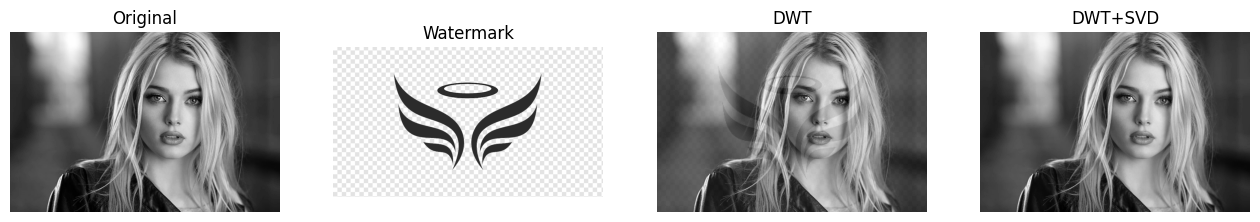

In [88]:
# original image
plt.figure(figsize=(16, 16))
plt.subplot(1, 4, 1)
plt.imshow(image, cmap='gray')
plt.title('Original')
plt.axis('off')

# watermark image
plt.subplot(1, 4, 2)
plt.imshow(watermark, cmap='gray')
plt.title('Watermark')
plt.axis('off')

#marked image with DWT watermark
plt.subplot(1, 4, 3)
plt.imshow(marked_image_dwt, cmap='gray')
plt.title('DWT')
plt.axis('off')

# marked image with DWT+SVD watermark
plt.subplot(1, 4, 4)
plt.imshow(marked_image_dwt_svd, cmap='gray')
plt.title('DWT+SVD')
plt.axis('off')

plt.show()


In [89]:
print("DWT:")
print(f"SSIM: {ssim(watermark, extracted_watermark_dwt_resized)}")
print(f"PSNR: {psnr(watermark, extracted_watermark_dwt_resized)}", "\n\n")

print("\nDWT+SVD:")
print(f"SSIM: {ssim(watermark, extracted_watermark_dwt_svd_resized)}")
print(f"PSNR: {psnr(watermark, extracted_watermark_dwt_svd_resized)}", "\n\n")


DWT:
SSIM: 0.8915151688894081
PSNR: 28.774364310472652 



DWT+SVD:
SSIM: 0.1477675334906797
PSNR: -24.052723113311632 




<ipython-input-89-a49430d135c5>:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  print(f"PSNR: {psnr(watermark, extracted_watermark_dwt_resized)}", "\n\n")
<ipython-input-89-a49430d135c5>:7: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  print(f"PSNR: {psnr(watermark, extracted_watermark_dwt_svd_resized)}", "\n\n")
